## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Read in Data

In [ ]:
df = pd.read_csv('data/preprocessed_log_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'TaskName', 'Transmission', 'IsHybrid', 'DriveType'], inplace=True) # Drop TaskName as all are 'Logbook'
df.head()

,TaskName,Odometer,Make,Model,FuelType,EngineSize,Distance,Months,AdjustedPrice
1,Logbook Service,72199.0,SKODA,SKODA FABIA III,Petrol,1.0,75000.0,60.0,710.0
4,Logbook Service,81168.0,MAZDA,MAZDA CX-9,Petrol,2.5,80000.0,96.0,586.0
5,Logbook Service,33541.0,MAZDA,MAZDA 3,Petrol,2.0,60000.0,72.0,384.0
6,Logbook Service,54040.0,TOYOTA,TOYOTA HILUX,Diesel,2.8,60000.0,36.0,477.0
8,Logbook Service,40557.0,FORD,FORD RANGER,Diesel,2.0,45000.0,36.0,656.0


In [3]:
df['Distance'] = df['Distance'].fillna(df['Odometer'])
df.drop(columns=['Odometer'], inplace=True)

In [4]:
model_counts = df['Model'].value_counts()

# Keep only models that appear at least 10 times
models_to_keep = model_counts[model_counts >= 10].index

# Filter the DataFrame
df = df[df['Model'].isin(models_to_keep)]

In [5]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       
cat_feature_indices = [0, 1, 2]

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [7]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_val.select_dtypes(include='object').columns:
   X_val[col] = X_val[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [9]:
model = CatBoostRegressor(
    eval_metric='MAPE',
    loss_function='RMSEWithUncertainty',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=0,
    thread_count=4
)

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
}


random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=25,            
    cv=3,                 
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

In [10]:
random_search.fit(
    X_train, y_train,
    cat_features=cat_feature_indices,
    early_stopping_rounds=200
)

print("Best params:", random_search.best_params_)
print("Best CV score (MAPE):", -random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 3.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 3.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time= 5.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 3.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 7.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time= 7.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 7.4min
[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 7.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time= 7.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time= 7.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time= 5.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 5.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time= 5.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 3.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 3.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 3.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 4.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 4.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 4.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 5.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time= 4.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 5.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 5.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 3.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time= 4.8min
[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time= 4.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time= 7.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time= 7.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time= 7.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time= 8.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time= 8.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time= 8.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 5.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 2.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 2.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 2.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 3.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 3.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 2.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time= 5.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 4.5min
[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 4.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time= 5.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 4.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.6min
[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 3.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 3.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 2.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 2.2min
Best params: {'subsample': 1.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 1500, 'depth': 10, 'colsample_bylevel': 0.8}
Best CV score (MAPE): nan


In [11]:
best_params = random_search.best_params_

best_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    random_seed=42,
    verbose=100
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

0:	learn: 0.3634965	test: 0.3869666	best: 0.3869666 (0)	total: 35.3ms	remaining: 52.9s
100:	learn: 0.1986690	test: 0.2168942	best: 0.2168942 (100)	total: 2.19s	remaining: 30.3s
200:	learn: 0.1856745	test: 0.2048024	best: 0.2048024 (200)	total: 4.34s	remaining: 28s
300:	learn: 0.1796145	test: 0.1999726	best: 0.1999726 (300)	total: 6.63s	remaining: 26.4s
400:	learn: 0.1757333	test: 0.1971780	best: 0.1971731 (399)	total: 8.94s	remaining: 24.5s
500:	learn: 0.1736293	test: 0.1957462	best: 0.1957462 (500)	total: 11.1s	remaining: 22.1s
600:	learn: 0.1717014	test: 0.1943478	best: 0.1943478 (600)	total: 13.2s	remaining: 19.7s
700:	learn: 0.1700644	test: 0.1934251	best: 0.1934251 (700)	total: 15.1s	remaining: 17.3s
800:	learn: 0.1689472	test: 0.1931378	best: 0.1931350 (799)	total: 17.4s	remaining: 15.2s
900:	learn: 0.1676601	test: 0.1925255	best: 0.1925255 (900)	total: 19.5s	remaining: 13s
1000:	learn: 0.1666796	test: 0.1921839	best: 0.1921797 (999)	total: 21.6s	remaining: 10.8s
1100:	learn: 0.1

In [12]:
y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAE: 93.53857647798529
RMSE: 157.1389021666982
MAPE: 17.53%


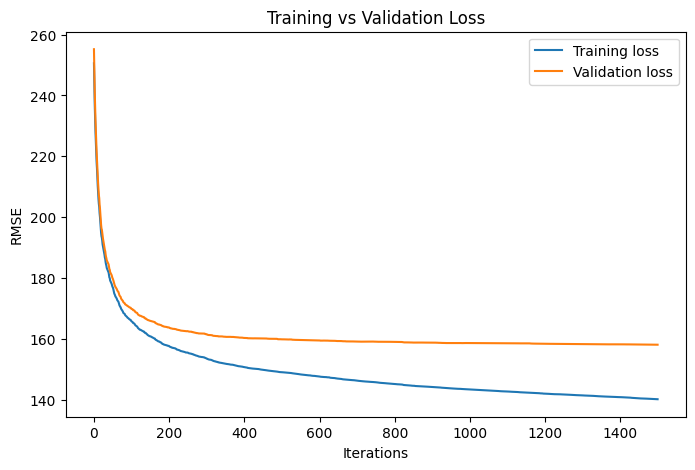

In [13]:
evals_result = best_model.get_evals_result()

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(evals_result['learn']['RMSE'], label='Training loss')
plt.plot(evals_result['validation']['RMSE'], label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

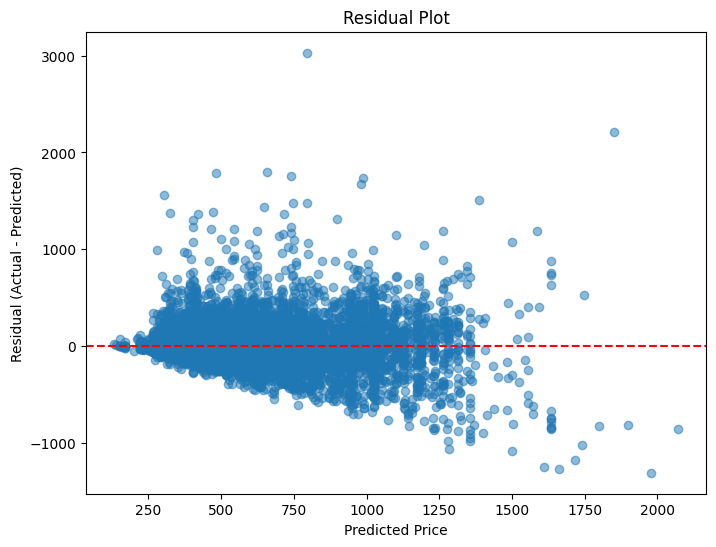

In [14]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

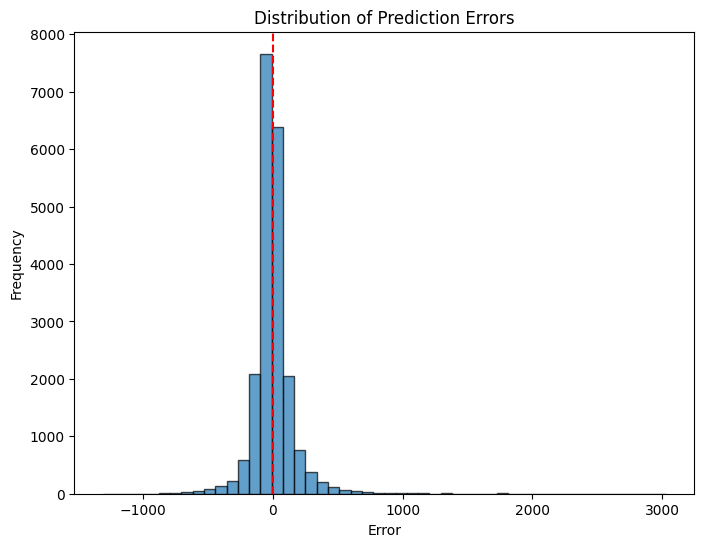

In [15]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

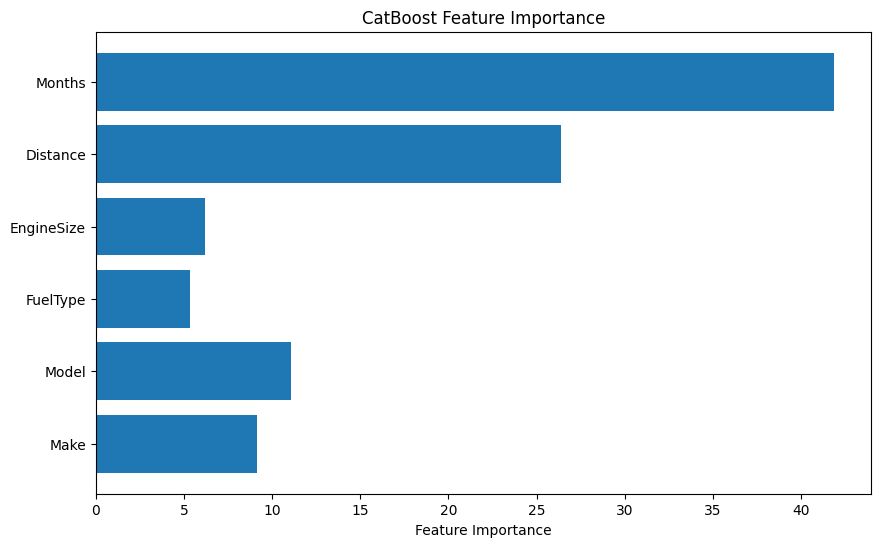

In [16]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


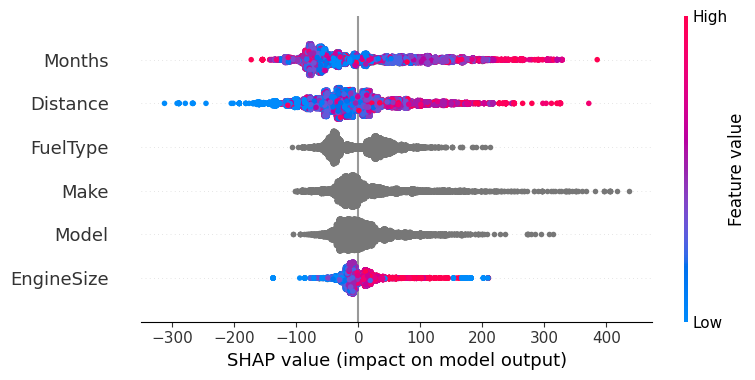

In [17]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


In [18]:
best_model.save_model('models/logbook_model.cbm')